## The data contains various user queries categorized into three intents.
### We will be using bert to train our model into recognizing these intents

### Loading data and other imports

In [2]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [2]:
from bert import BertModelLayer

In [4]:
train = pd.read_csv("HT_train.csv")
valid = pd.read_csv("HT_valid.csv")
test = pd.read_csv("HT_test.csv")

In [5]:
train = train.append(valid).reset_index(drop=True)

In [6]:
train.head()

,text,intent
0,tell me about qutub minar,Details
1,create my itinerary,CreateItinerary
2,create my itinerary for pune,CreateItinerary
3,know about char minar,Details
4,book my hotel,Book


### Visualizing number of queries per intent

Text(0.5, 1.0, 'Number of texts per intent')

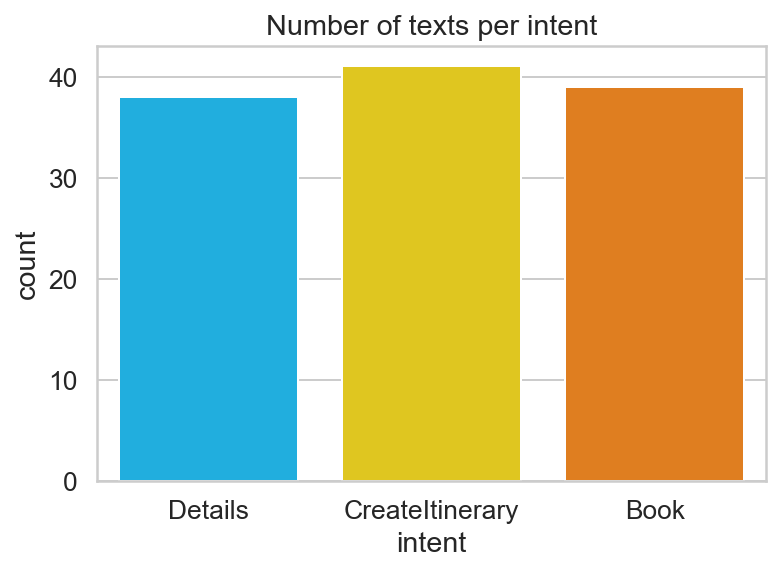

In [8]:
sns.countplot(train.intent)
plt.title("Number of texts per intent")

### Downloading the bert model from https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip and naming it as intent
### Moving the downloaded model to a folder named 'model2'

In [7]:
os.makedirs("model2", exist_ok=True)

In [8]:
!mv intent/ model2

mv: cannot stat 'intent/': No such file or directory


In [8]:
bert_model_name="intent"

bert_ckpt_dir = os.path.join("model2/", bert_model_name)    #checkpoint directory
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt") #checkpoint file
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")  #configuration file

### Pre-processing the data by tokenization and padding 

In [9]:
class IntentDetectionData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "intent"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    train, test = map(lambda df: df.reindex(df[IntentDetectionData.DATA_COLUMN].str.len().sort_values().index), [train, test])
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)      
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [10]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [11]:
tokenizer.tokenize("I can't wait to visit Bulgaria again!")

['i', 'can', "'", 't', 'wait', 'to', 'visit', 'bulgaria', 'again', '!']

In [12]:
tokens = tokenizer.tokenize("I can't wait to visit Bulgaria again!")
tokenizer.convert_tokens_to_ids(tokens)

[1045, 2064, 1005, 1056, 3524, 2000, 3942, 8063, 2153, 999]

### Fine Tuning the bert model by adding keras layers and 2 Dropouts to prevent overfitting
### The model will return outputs equal to our no. of intents

In [13]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

### The 'classes' variable holds a list of unique intents
### creating the 'data' instance of class 'IntentDetectionData' 

In [14]:
classes = train.intent.unique().tolist()

data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

118it [00:00, 4916.73it/s]
64it [00:00, 2134.35it/s]


max seq_len 12


In [15]:
data.train_x.shape

(118, 12)

### Creating model

In [16]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 12, 768)
Done loading 196 BERT weights from: model2/intent\bert_model.ckpt into <bert.model.BertModelLayer object at 0x0000024259394648> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 12)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 12, 768)           108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 2307  

### Compiling model and definig the loss function, optimizer and metrics

In [18]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

### Fitting the model to training data

In [19]:

# log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
# tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5,
#   callbacks=[tensorboard_callback]
)

Train on 106 samples, validate on 12 samples
Epoch 1/5
106/106 [==============================] - ETA: 7:54 - loss: 1.1467 - acc: 0.312 - ETA: 4:03 - loss: 1.1666 - acc: 0.250 - ETA: 2:10 - loss: 1.1445 - acc: 0.312 - ETA: 1:12 - loss: 1.1298 - acc: 0.328 - ETA: 36s - loss: 1.1134 - acc: 0.362 - ETA: 11s - loss: 1.1180 - acc: 0.35 - 185s 2s/sample - loss: 1.1117 - acc: 0.3585 - val_loss: 1.0940 - val_acc: 0.2500
Epoch 2/5
106/106 [==============================] - ETA: 2:16 - loss: 1.0773 - acc: 0.375 - ETA: 1:22 - loss: 1.0615 - acc: 0.437 - ETA: 46s - loss: 1.0775 - acc: 0.458 - ETA: 26s - loss: 1.0720 - acc: 0.45 - ETA: 14s - loss: 1.0484 - acc: 0.51 - ETA: 4s - loss: 1.0364 - acc: 0.5312 - 60s 563ms/sample - loss: 1.0317 - acc: 0.5377 - val_loss: 1.0361 - val_acc: 0.5833
Epoch 3/5
106/106 [==============================] - ETA: 10s - loss: 0.9871 - acc: 0.50 - ETA: 9s - loss: 0.9968 - acc: 0.5625 - ETA: 7s - loss: 0.9945 - acc: 0.541 - ETA: 5s - loss: 0.9904 - acc: 0.562 - ETA: 3s 

### Visualizing loss over training epochs

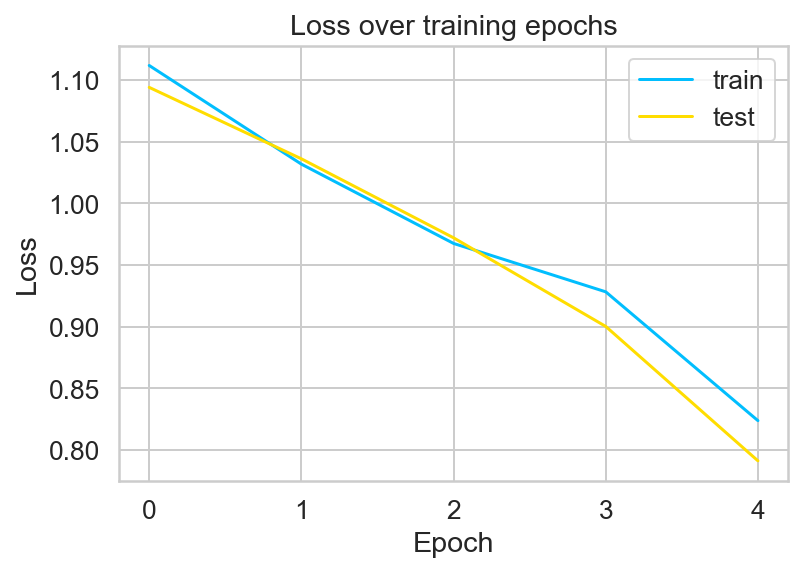

In [20]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

### Visualizing accuracy over training epochs

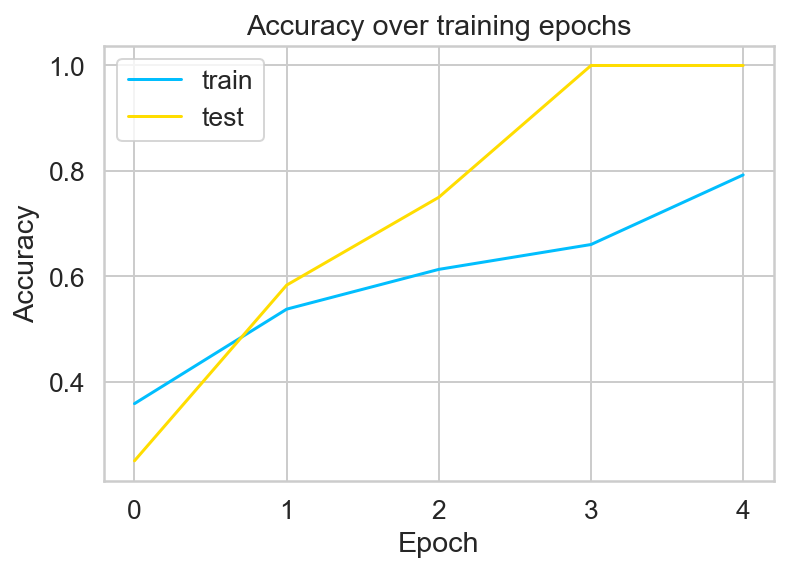

In [21]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [22]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

64/64 [==============================] - ETA: 38s - loss: 0.6089 - acc: 1.00 - 40s 626ms/sample - loss: 0.6398 - acc: 1.0000
train acc 0.9576271
test acc 1.0


In [23]:
y_pred = model.predict(data.test_x).argmax(axis=-1)
y_pred

array([1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 0, 1,
       1, 1, 2, 1, 0, 2, 1, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 1,
       2, 1, 0, 2, 2, 0, 1, 2, 2, 0, 2, 1, 1, 1, 1, 1, 0, 1, 0, 0],
      dtype=int64)

### Classification Report

In [24]:
print(classification_report(data.test_y, y_pred, target_names=classes))

                 precision    recall  f1-score   support

        Details       1.00      1.00      1.00        18
CreateItinerary       1.00      1.00      1.00        25
           Book       1.00      1.00      1.00        21

       accuracy                           1.00        64
      macro avg       1.00      1.00      1.00        64
   weighted avg       1.00      1.00      1.00        64



### Predicting a query's intent and returning the intent class

In [25]:

sentences = [
  "can you create an itinerary?",
#   "hotel booking",
#   "tell fort"
#     "where is amer fort",
#     "plan my trip"
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

# for text, label in zip(sentences, predictions):
#   print("text:", text, "\nintent:", classes[label])
#   print()
if predictions==0:
    x="Details"
elif predictions==1:
    x="Create"
else:
    x="Book"
print(x)

Create


In [25]:
print(predictions)
print(type(predictions))
print(type(sentences))
print(type(classes[label]))

[0]
<class 'numpy.ndarray'>
<class 'list'>
<class 'str'>


### Confusion Matrix

In [72]:
print(confusion_matrix(data.test_y, y_pred))

[[18  0  0]
 [ 0 25  0]
 [ 0  0 21]]
